# Confusion matrices final multi-source localization models 
Confusion matrices over azimuth and elevation for the final multi-source localization models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import keras
import seaborn as sns

# Array of dictionaries of the labels at their indeces
azimuth_values = [270, 280, 290, 300, 310, 320, 330, 340, 350, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
elevation_values= [60, 45, 30, 20, 10, 0, -10, -20, -30, -45]
positions_dict = []
for az in azimuth_values: 
  for el in elevation_values:
    positions_dict.append({'azimuth': az, 'elevation': el})


# take index of max probability class from the output probability array: creates array of predicted labels
def max_multi_pred(predict):
    max_preds = []
    max_probs = []
    for i in range(len(predict)):
        max1 = 0
        max2 = 0
        prob1 = 0
        prob2 = 0
        for j in range(len(predict[i])):
            if predict[i][j] > predict[i][max1]:
                max2 = max1
                max1 = j
                prob2 = prob1
                prob1 = predict[i][j]
                # print("max1: ", max1)
            elif predict[i][j] > predict[i][max2]:
                max2 = j
                prob2 = predict[i][j]
        max_preds.append(np.array([max1, max2]))
        max_probs.append(np.array([prob1, prob2]))
    return max_preds, max_probs

# altered square function that is explained in thesis
def sqr_error(t, p):
    err_az = abs( float(positions_dict[t]['azimuth']) - float(positions_dict[p]['azimuth']) )**2 + 0.1
    err_el = abs( float(positions_dict[t]['elevation']) - float(positions_dict[p]['elevation']) )**2 + 0.1
    return (err_az * err_el)

# correctly pairing the true-predict label pairs
def extract_label_pairs(true, predict):
    correct_pairs = []
    for i in range(len(predict)):
        max1 = 0
        max2 = 0
        o1 = sqr_error(true[i][0], predict[i][0]) * sqr_error(true[i][1], predict[i][1])
        o2 = sqr_error(true[i][1], predict[i][0]) * sqr_error(true[i][0], predict[i][1])
        if o1 < o2:
            max1 = predict[i][0]
            max2 = predict[i][1]
        else:
            max1 = predict[i][1]
            max2 = predict[i][0]
        pairs = [max1, max2]
        correct_pairs.append(pairs)
    correct_pairs = np.array(correct_pairs)
    return correct_pairs


In [2]:
# putting predictions in bins of azimuth
def to_az(labels):
    to_az = []
    for t in labels:
        label_az = t // 10
        to_az.append(label_az)
    to_az = np.array(to_az)
    return to_az

#putting predictions in bins of elevation
def to_el(labels):
    to_el = []
    for t in labels:
        label_el = t % 10
        to_el.append(label_el)
    to_el = np.array(to_el)
    return to_el

#plotting confusion matrices
def confusion_matrices(true_labels, predict_labels, label_k, az_ticks, el_ticks):
    print(f"{label_k} total accuracy: ", metrics.accuracy_score(true_labels, predict_labels))
    true_az = to_az(true_labels)
    pred_az = to_az(predict_labels)
    true_el = to_el(true_labels)
    pred_el = to_el(predict_labels)
    print(f"{label_k} accuracy azimuth: ", metrics.accuracy_score(true_az, pred_az))
    print(f"{label_k} accuracy elevation: ", metrics.accuracy_score(true_el, pred_el))
    bin_acc = keras.metrics.BinaryAccuracy() #https://keras.io/api/metrics/accuracy_metrics/
    bin_acc.update_state(true_labels, predict_labels)
    print(f"{label_k} total binary accuracy:", bin_acc.result())
    bin_acc.reset_state()
    bin_acc.update_state(true_az, pred_az)
    print(f"{label_k} azimuth binary accuracy:", bin_acc.result())
    bin_acc.reset_state()
    bin_acc.update_state(true_el, pred_el)
    print(f"{label_k} elevation binary accuracy:", bin_acc.result())
    
    fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(8.8, 3.9), constrained_layout = True)
    fig.suptitle(f'Confusion matrix {label_k}', size = 18)
    fig.get_layout_engine().set(hspace=0.2,
                            wspace=0.1)

    cma_display = metrics.ConfusionMatrixDisplay.from_predictions(true_az, 
                                                              pred_az, 
                                                              display_labels = [270, "", "", 300, "", "", 330, "", "", 0, 
                                                                   "", "", 30, "", "", 60, "", "", 90],
                                                              include_values = False, 
                                                              normalize = 'true', 
                                                              values_format= '.0%')
    sns.heatmap(cma_display.confusion_matrix, cbar=False, vmin=0, 
                cmap='viridis', 
                xticklabels=[270, "", "", 300, "", "", 330, "", "", 0, "", "", 30, "", "", 60, "", "", 90], 
                yticklabels=[270, "", "", 300, "", "", 330, "", "", 0, "", "", 30, "", "", 60, "", "", 90],
               ax=ax1)
    cbar = ax1.figure.colorbar(ax1.collections[0])
    cbar.set_ticks(az_ticks['ticks'])
    cbar.set_ticklabels(az_ticks['ticklabels'])
    cbar.set_label("Accuracy (%)")

    ax1.set_title("Performance (azimuth)", size = 14)
    ax1.set_xlabel("Predicted location (degrees)")
    ax1.set_ylabel("Actual location (degrees)")
    
    
    # ax2.set_title("Elevation", fontsize = 16)
    cma_display = metrics.ConfusionMatrixDisplay.from_predictions(true_el, 
                                                              pred_el, 
                                                              display_labels = [60, 45, 30, 20, 10, 0, -10, -20, -30, -45],
                                                              include_values = False, 
                                                              normalize = 'true', 
                                                              values_format= '.0%')
    
    sns.heatmap(cma_display.confusion_matrix, cbar=False, vmin=0, 
                      cmap='viridis', 
                      xticklabels=[60, 45, 30, 20, 10, 0, -10, -20, -30, -45], 
                      yticklabels=[60, 45, 30, 20, 10, 0, -10, -20, -30, -45], ax=ax2)
    cbar = ax2.figure.colorbar(ax2.collections[0])
    cbar.set_ticks(el_ticks['ticks'])
    cbar.set_ticklabels(el_ticks['ticklabels'])
    cbar.set_label("Accuracy (%)")

    ax2.set_title("Performance (elevation)", size = 14)
    ax2.set_xlabel("Predicted location (degrees)")
    ax2.set_ylabel("Actual location (degrees)")

    plt.show()    
   

# function to take the first (m=0) or second (m=1) label pairing of the label array (labs)
def label_spec(labs, m):
    lis = []
    for i in range(len(labs)):
        lis.append(labs[i][m])
    lis = np.array(lis)
    return lis

all labels: total accuracy:  0.01721777590564448
all labels: accuracy azimuth:  0.11099410278011794
all labels: accuracy elevation:  0.15906697556866048
all labels: total binary accuracy: tf.Tensor(0.0048967986, shape=(), dtype=float32)
all labels: azimuth binary accuracy: tf.Tensor(0.04749368, shape=(), dtype=float32)
all labels: elevation binary accuracy: tf.Tensor(0.09714617, shape=(), dtype=float32)


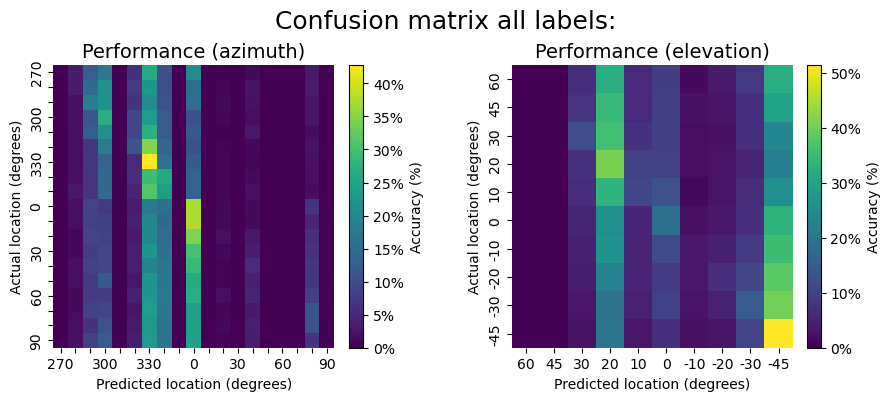

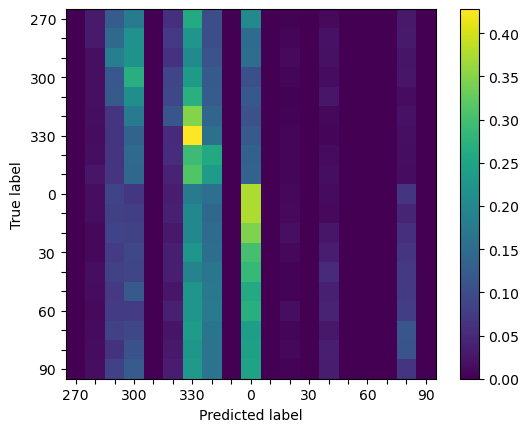

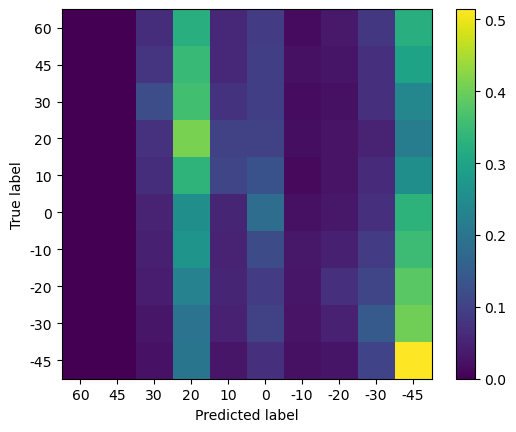

first label: total accuracy:  0.010741364785172704
first label: accuracy azimuth:  0.09856781802864364
first label: accuracy elevation:  0.16143639427127213
first label: total binary accuracy: tf.Tensor(0.0052653747, shape=(), dtype=float32)
first label: azimuth binary accuracy: tf.Tensor(0.05265375, shape=(), dtype=float32)
first label: elevation binary accuracy: tf.Tensor(0.09993681, shape=(), dtype=float32)


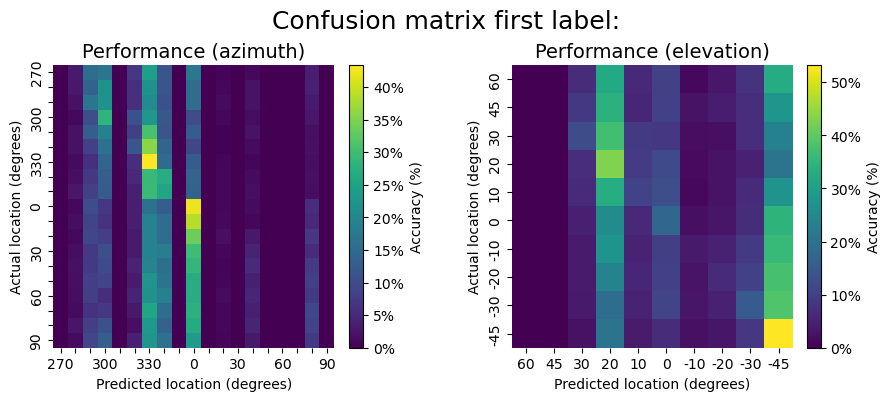

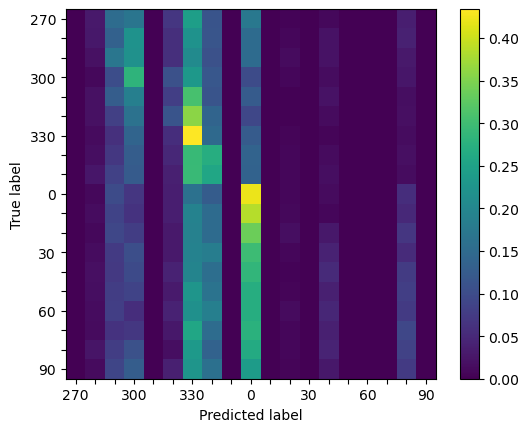

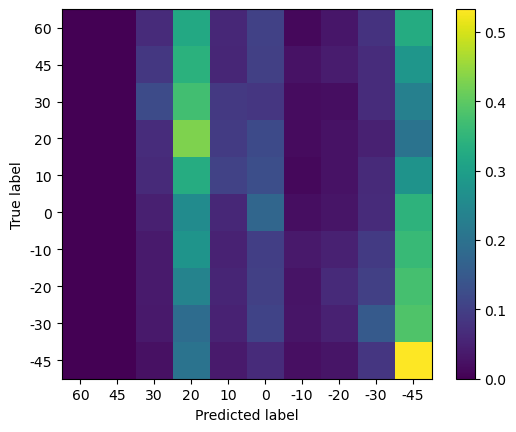

second label: total accuracy:  0.02369418702611626
second label: accuracy azimuth:  0.12342038753159225
second label: accuracy elevation:  0.15669755686604886
second label: total binary accuracy: tf.Tensor(0.0045282226, shape=(), dtype=float32)
second label: azimuth binary accuracy: tf.Tensor(0.042333614, shape=(), dtype=float32)
second label: elevation binary accuracy: tf.Tensor(0.094355516, shape=(), dtype=float32)


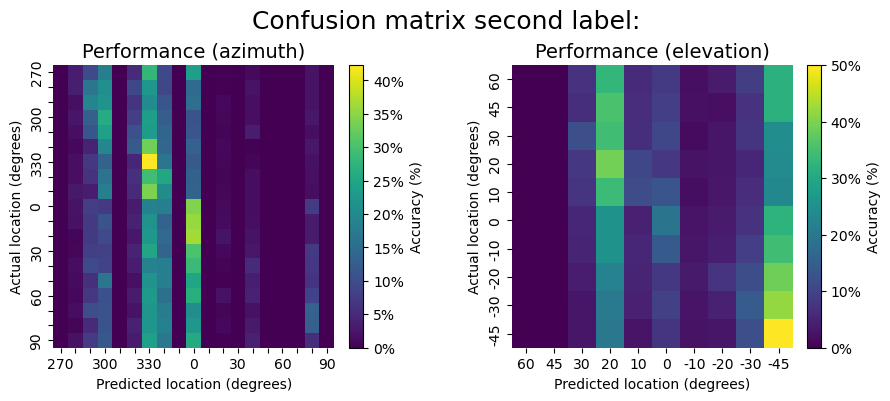

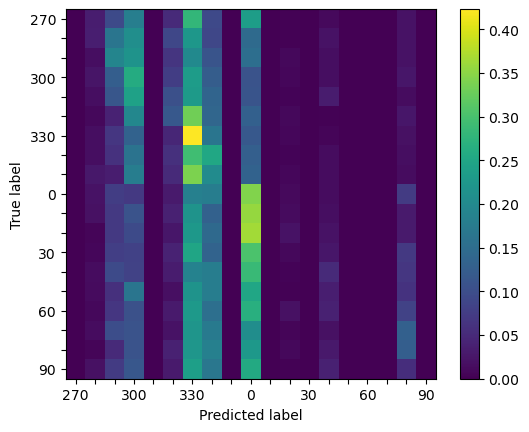

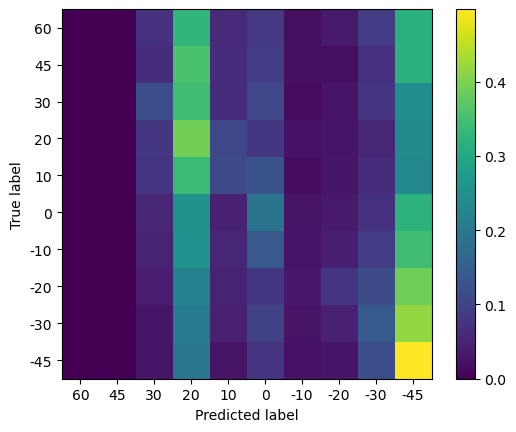

In [3]:
# Plot results of multi-source model
predict = np.load('final_predictions/goodEpoch_MultiSource.npz')['arr_0'] #load output arrays
max_preds, max_probs = max_multi_pred(predict)
true = np.load('name_labels_test_multi.npz')['arr_1']
true_labels = true[:predict.shape[0]] # make sure the predictions.size == trues.size because batch size gives modulo>0

correct_pred_pairs = extract_label_pairs(true_labels, max_preds)

az_ticks = {'ticks':[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40], 'ticklabels':["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%"]}
el_ticks = {'ticks':[0, 0.1, 0.2, 0.3, 0.40, 0.50], 'ticklabels':["0%", "10%", "20%", "30%", "40%", "50%"]}

#plot confusion matrices of all labels (1st and 2nd, so flattened array)
full_true = true_labels.flatten()
full_pred = correct_pred_pairs.flatten()
confusion_matrices(full_true, full_pred, "all labels:", az_ticks, el_ticks)

# plot only first label
first_true = label_spec(true_labels, 0)
first_pred = label_spec(correct_pred_pairs, 0)
confusion_matrices(first_true, first_pred, "first label:", az_ticks, el_ticks)

#plot only second label
sec_true = label_spec(true_labels, 1)
sec_pred = label_spec(correct_pred_pairs, 1)
confusion_matrices(sec_true, sec_pred, "second label:", az_ticks, el_ticks)

all labels: total accuracy:  0.011899747262005055
all labels: accuracy azimuth:  0.09883108677337826
all labels: accuracy elevation:  0.16628053917438923
all labels: total binary accuracy: tf.Tensor(0.0048967986, shape=(), dtype=float32)
all labels: azimuth binary accuracy: tf.Tensor(0.048125528, shape=(), dtype=float32)
all labels: elevation binary accuracy: tf.Tensor(0.09714617, shape=(), dtype=float32)


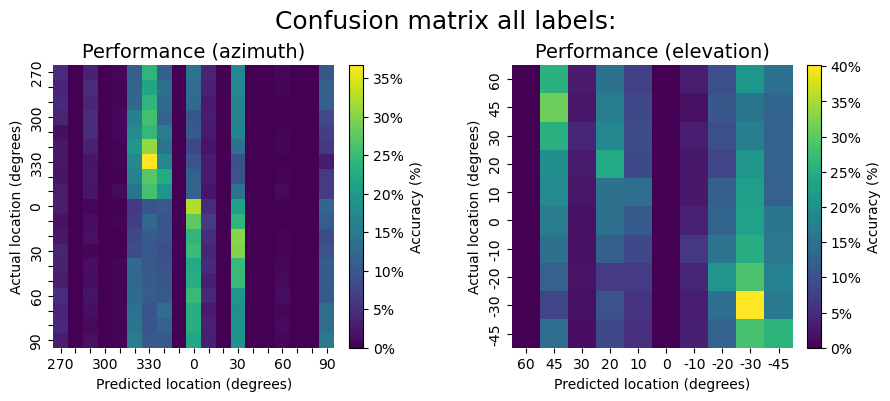

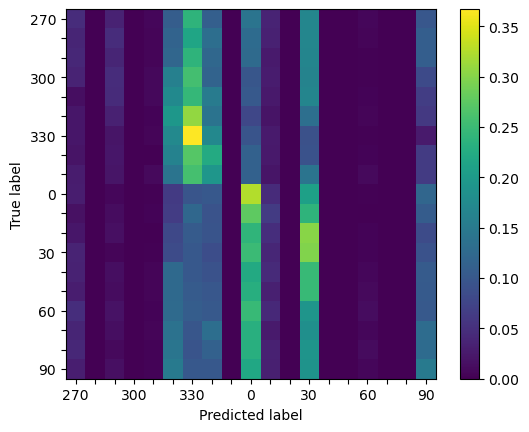

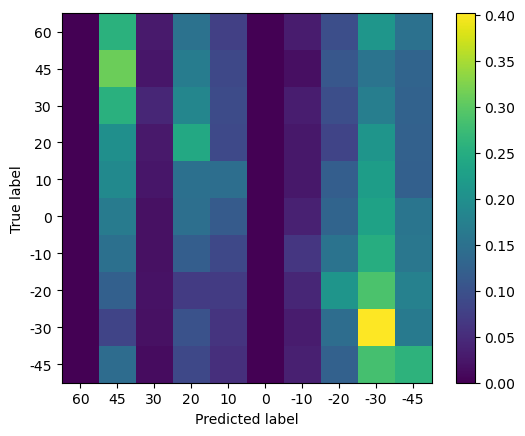

first label: total accuracy:  0.009477674810446503
first label: accuracy azimuth:  0.09446082561078349
first label: accuracy elevation:  0.1707034540859309
first label: total binary accuracy: tf.Tensor(0.0052653747, shape=(), dtype=float32)
first label: azimuth binary accuracy: tf.Tensor(0.05307498, shape=(), dtype=float32)
first label: elevation binary accuracy: tf.Tensor(0.09993681, shape=(), dtype=float32)


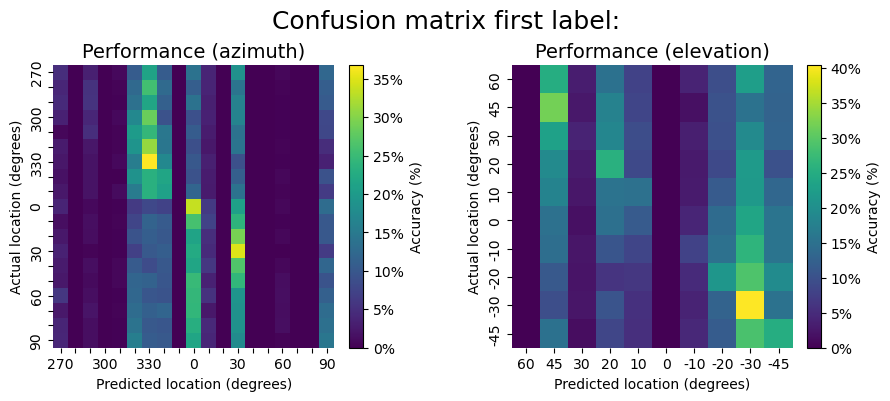

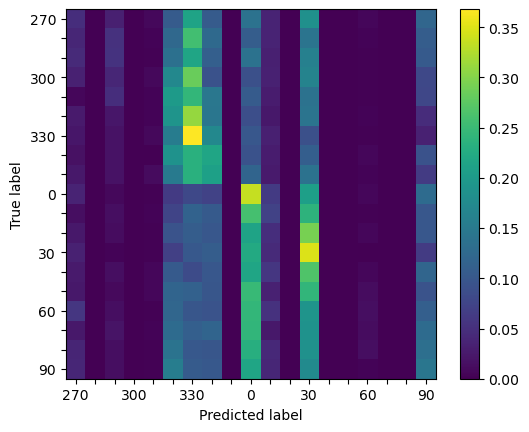

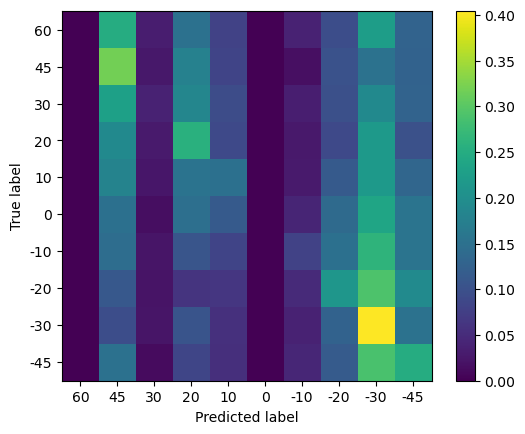

second label: total accuracy:  0.014321819713563605
second label: accuracy azimuth:  0.10320134793597305
second label: accuracy elevation:  0.16185762426284753
second label: total binary accuracy: tf.Tensor(0.0045282226, shape=(), dtype=float32)
second label: azimuth binary accuracy: tf.Tensor(0.043176074, shape=(), dtype=float32)
second label: elevation binary accuracy: tf.Tensor(0.094355516, shape=(), dtype=float32)


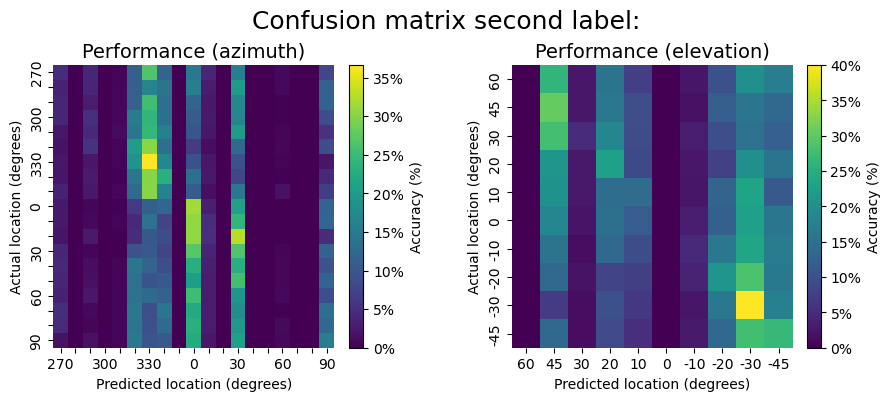

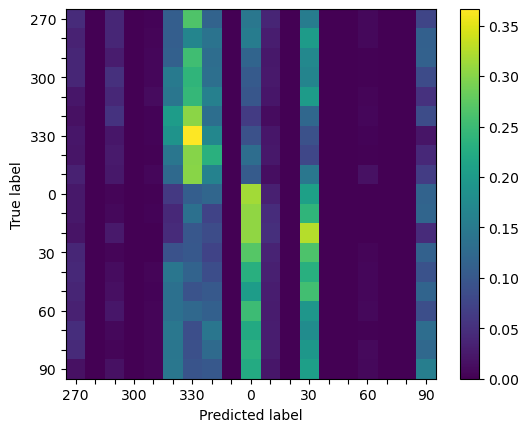

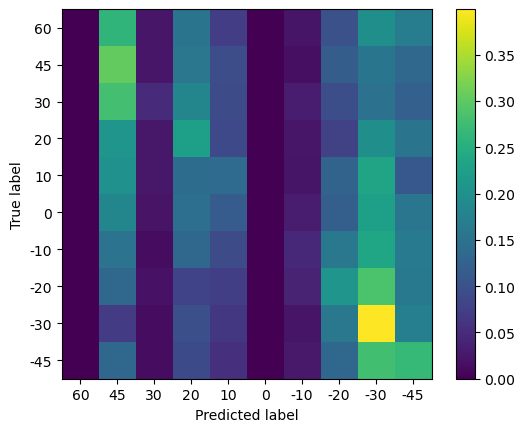

In [4]:
#plot results of altered multi-source model (with learning rate of 1e-5)
predict = np.load('final_predictions/goodEpoch_MultiSource_LR_1e-5.npz')['arr_0'] #load output array
max_preds, max_probs = max_multi_pred(predict)
true = np.load('name_labels_test_multi.npz')['arr_1']
true_labels = true[:predict.shape[0]] # make sure the predictions.size == trues.size because batch size gives modulo>0

correct_pred_pairs = extract_label_pairs(true_labels, max_preds)

az_ticks = {'ticks':[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], 'ticklabels':["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%"]}
el_ticks = {'ticks':[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35,0.40], 'ticklabels':["0%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%"]}

#plot confusion matrices of all labels (1st and 2nd, so flattened array)
full_true = true_labels.flatten()
full_pred = correct_pred_pairs.flatten()
confusion_matrices(full_true, full_pred, "all labels:", az_ticks, el_ticks)

# plot only first label
first_true = label_spec(true_labels, 0)
first_pred = label_spec(correct_pred_pairs, 0)
confusion_matrices(first_true, first_pred, "first label:", az_ticks, el_ticks)

#plot only second label
sec_true = label_spec(true_labels, 1)
sec_pred = label_spec(correct_pred_pairs, 1)
confusion_matrices(sec_true, sec_pred, "second label:", az_ticks, el_ticks)

all labels: total accuracy:  0.01068871103622578
all labels: accuracy azimuth:  0.09977885425442291
all labels: accuracy elevation:  0.15495998315080034
all labels: total binary accuracy: tf.Tensor(0.0048967986, shape=(), dtype=float32)
all labels: azimuth binary accuracy: tf.Tensor(0.048072875, shape=(), dtype=float32)
all labels: elevation binary accuracy: tf.Tensor(0.09714617, shape=(), dtype=float32)


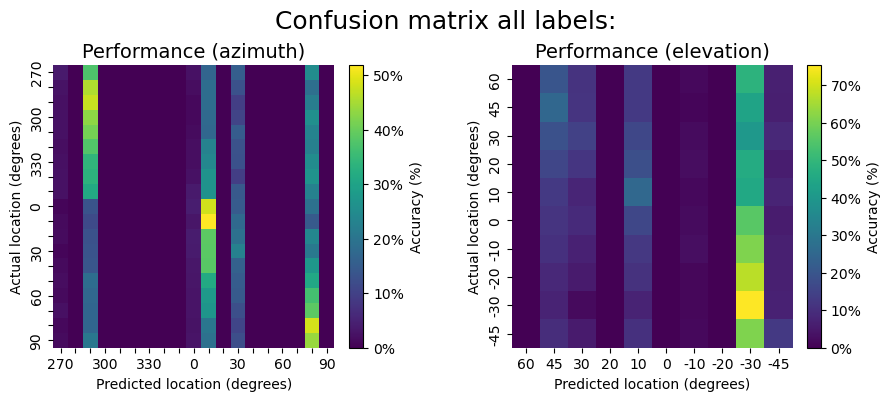

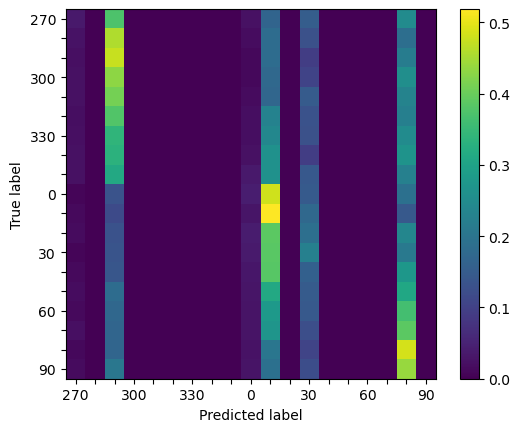

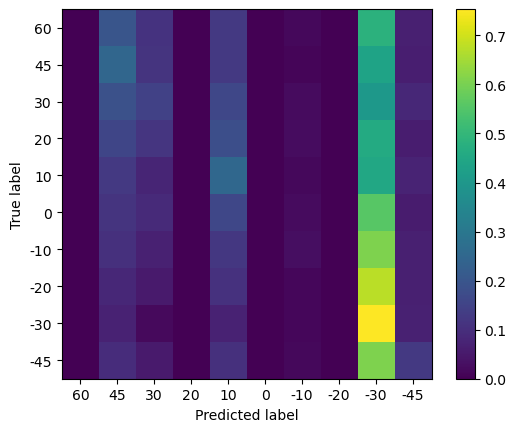

first label: total accuracy:  0.012110362257792755
first label: accuracy azimuth:  0.0971988205560236
first label: accuracy elevation:  0.15585509688289806
first label: total binary accuracy: tf.Tensor(0.0052653747, shape=(), dtype=float32)
first label: azimuth binary accuracy: tf.Tensor(0.053285595, shape=(), dtype=float32)
first label: elevation binary accuracy: tf.Tensor(0.09993681, shape=(), dtype=float32)


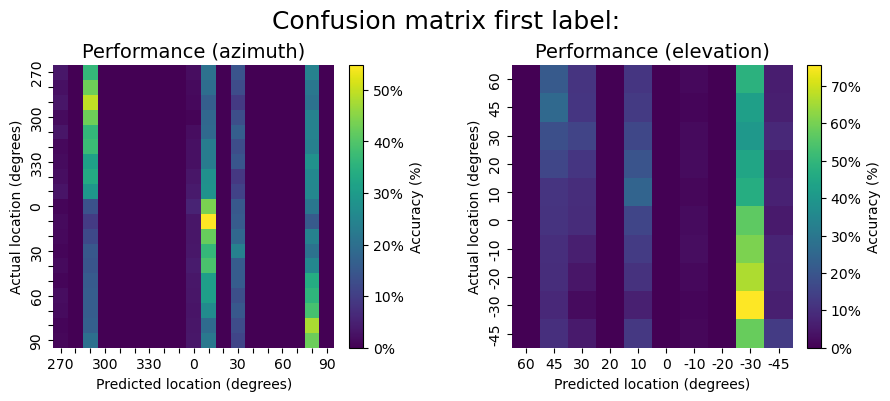

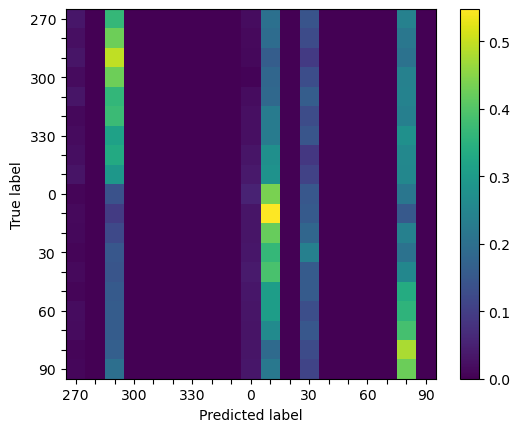

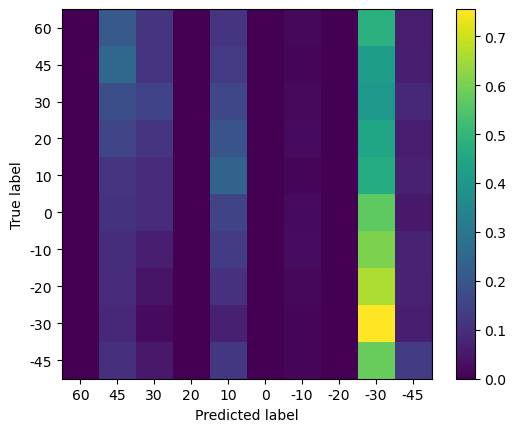

second label: total accuracy:  0.009267059814658803
second label: accuracy azimuth:  0.10235888795282225
second label: accuracy elevation:  0.15406486941870262
second label: total binary accuracy: tf.Tensor(0.0045282226, shape=(), dtype=float32)
second label: azimuth binary accuracy: tf.Tensor(0.04286015, shape=(), dtype=float32)
second label: elevation binary accuracy: tf.Tensor(0.094355516, shape=(), dtype=float32)


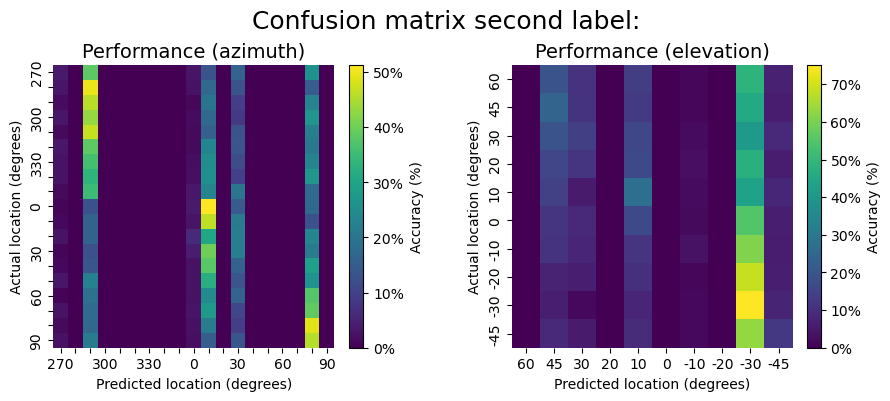

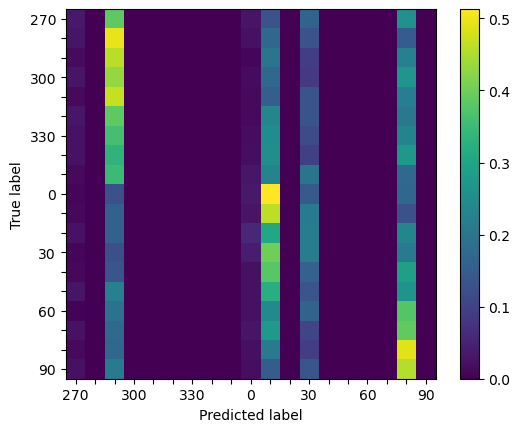

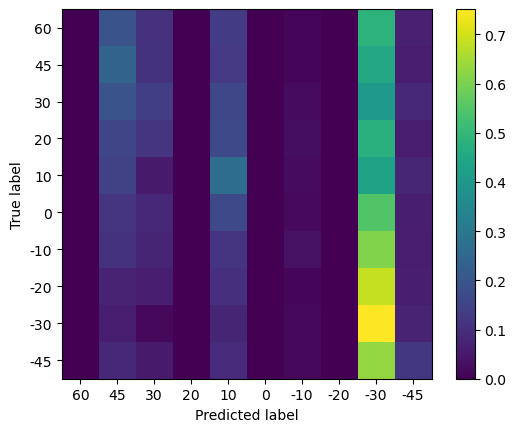

In [6]:
#plot results of single-source model on multi-source data 
predict = np.load('final_predictions/single_on_multi.npz')['arr_0'] #load output array
max_preds, max_probs = max_multi_pred(predict)
true = np.load('name_labels_test_multi.npz')['arr_1']
true_labels = true[:predict.shape[0]] # make sure the predictions.size == trues.size because batch size gives modulo>0

correct_pred_pairs = extract_label_pairs(true_labels, max_preds)

az_ticks = {'ticks':[0, 0.1, 0.2, 0.3, 0.40, 0.50], 'ticklabels':["0%", "10%", "20%", "30%", "40%", "50%"]}
el_ticks = {'ticks':[0, 0.1, 0.2, 0.3, 0.40, 0.50, 0.60, 0.70], 'ticklabels':["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"]}

#plot confusion matrices of all labels (1st and 2nd, so flattened array)
full_true = true_labels.flatten()
full_pred = correct_pred_pairs.flatten()
confusion_matrices(full_true, full_pred, "all labels:", az_ticks, el_ticks)

# plot only first label
first_true = label_spec(true_labels, 0)
first_pred = label_spec(correct_pred_pairs, 0)
confusion_matrices(first_true, first_pred, "first label:", az_ticks, el_ticks)

#plot only second label
sec_true = label_spec(true_labels, 1)
sec_pred = label_spec(correct_pred_pairs, 1)
confusion_matrices(sec_true, sec_pred, "second label:", az_ticks, el_ticks)
